In [17]:
import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from model import create_model
from dataset import AlbumentationsTransform 
from albumentations.pytorch import ToTensorV2
import albumentations as A

In [2]:
val_dir = "../data/val"
model_path = "../models/best_model_finetuned.pth"

In [3]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
class_names = val_dataset.classes
num_classes = len(class_names)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(num_classes)
state_dict = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()
model.to(device)

In [42]:
all_preds = []
all_labels = []
all_probs = []
all_paths = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs.to(device)
        labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)        

In [12]:
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

📊 Classification Report:
              precision    recall  f1-score   support

   cardboard     0.9322    0.9167    0.9244        60
       glass     0.8974    0.9333    0.9150        75
       metal     0.9032    0.9180    0.9106        61
       paper     0.9111    0.9213    0.9162        89
     plastic     0.8649    0.8889    0.8767        72
       trash     0.7857    0.5500    0.6471        20

    accuracy                         0.8966       377
   macro avg     0.8824    0.8547    0.8650       377
weighted avg     0.8950    0.8966    0.8945       377



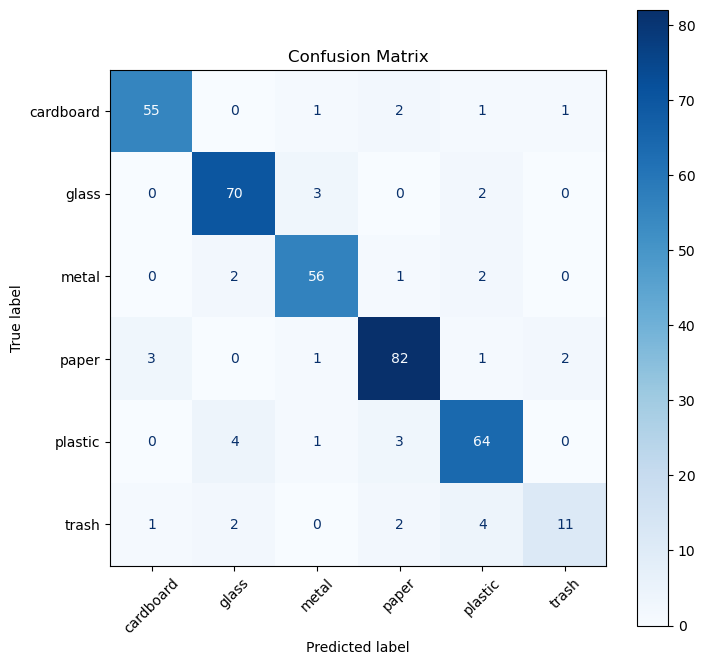

In [43]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

❌ Ошибок всего: 39


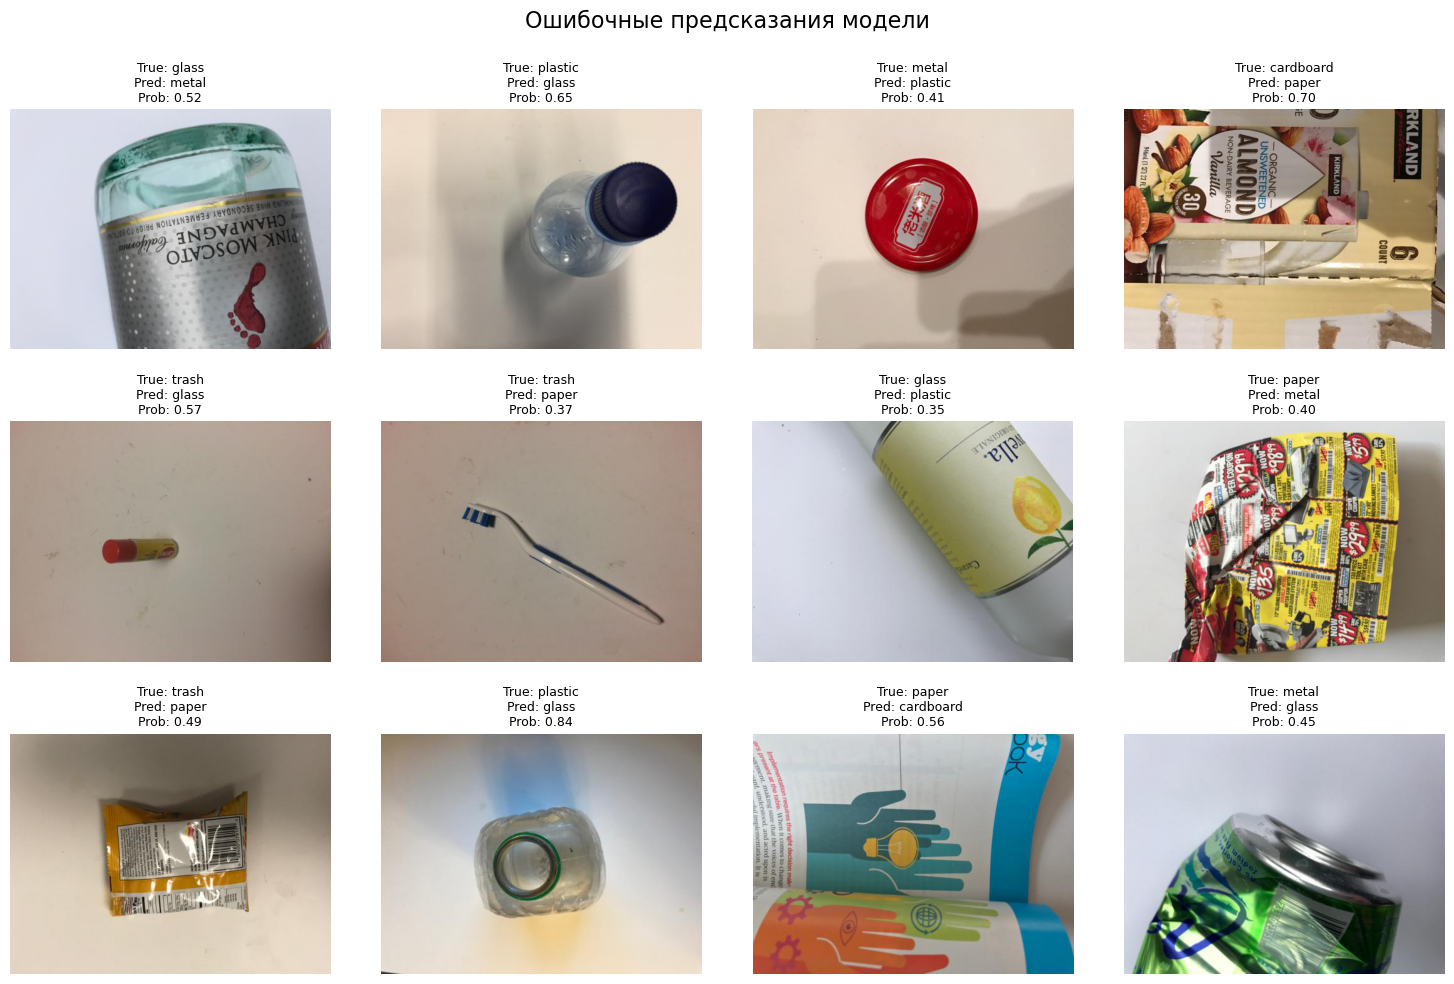

In [46]:
# Повторно прогоняем для получения путей
val_dataset_with_paths = datasets.ImageFolder(val_dir, transform=val_transform)

# Ошибки
incorrect_indices = np.where(all_preds != all_labels)[0]
print(f"❌ Ошибок всего: {len(incorrect_indices)}")

# Визуализируем N случайных ошибок
N = 12
selected_errors = np.random.choice(incorrect_indices, size=min(N, len(incorrect_indices)), replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(selected_errors):
    image_path, true_class = val_dataset_with_paths.samples[idx]
    image = val_dataset_with_paths.loader(image_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.axis('off')
    pred_label = class_names[all_preds[idx]]
    true_label = class_names[all_labels[idx]]
    prob = np.max(all_probs[idx])
    plt.title(f"True: {true_label}\nPred: {pred_label}\nProb: {prob:.2f}", fontsize=9)
plt.tight_layout()
plt.suptitle("Ошибочные предсказания модели", fontsize=16)
plt.subplots_adjust(top=0.88, hspace=0.3)
plt.show()